In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from matplotlib.patches import Rectangle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.stats import ttest_ind

In [2]:
path='/home/gsato/data-shell/'
file=['12_el_pi.nc','12_la_pi.nc','3_el_pi.nc','3_la_pi.nc','34_el_pi.nc','34_la_pi.nc',
      '4_el_pi.nc','4_la_pi.nc','12_el_mh.nc','12_la_mh.nc','3_el_mh.nc','3_la_mh.nc',
      '34_el_mh.nc','34_la_mh.nc','4_el_mh.nc','4_la_mh.nc']

In [6]:
#opening files
def open_file(x):
    return xr.open_dataset(path+file[x])

In [74]:
ds = open_file(8)
ds

<xarray.Dataset> Size: 162MB
Dimensions:  (time: 621, lon: 360, lat: 180)
Coordinates:
  * time     (time) object 5kB 0502-05-15 12:00:00 ... 0699-07-15 12:00:00
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    month    (time) int64 5kB ...
Data variables:
    sst      (time, lat, lon) float32 161MB ...
    slope    (lat, lon) float64 518kB ...
    mask     (lat, lon) float64 518kB ...

In [24]:
#C, or 5% statistical significance

def statis(x,y):

    sst_pi = open_file(x)['sst'].mean(dim='time')
    sst_mh = open_file(y)['sst'].mean(dim='time')
    diff_sst = sst_mh-sst_pi
    
    tstat,pval = ttest_ind(sst_mh, sst_pi, equal_var = False)
    
    #making a mask
    p = 0.05
    mask_sst = diff_sst.where(pval <= p)
    return diff_sst, mask_sst

In [47]:
statis(2,10
      )

(<xarray.DataArray 'sst' (lat: 180, lon: 360)> Size: 259kB
 array([[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.00100184, -0.00101032, -0.00101746, ..., -0.00097474,
         -0.0009833 , -0.000993  ],
        [-0.00096353, -0.00097178, -0.00097973, ..., -0.0009383 ,
         -0.00094682, -0.00095531],
        [-0.00096526, -0.0009714 , -0.00097808, ..., -0.00094966,
         -0.00095459, -0.00095979]], dtype=float32)
 Coordinates:
   * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
   * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5,
 <xarray.DataArray 'sst' (lat: 180, lon: 360)> Size: 259kB
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, na

In [88]:
0*2

0

In [97]:
#plot the differences
def mh_vs_pi(x):
    labels=["El Nino (6ka vs. 0ka)", "La Nina (6ka vs. 0ka)"]
    ENSO = ["Nino1+2", "Nino3", "Nino3.4", "Nino4"]
    clevs=np.arange(-0.5,0.6,0.01)
    hatch_levs=[0]

    # Define the figure and each axis for the 2 rows and 1 columns
    fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200.0)}, figsize=(11,5))

    #Loop over all of the seasons and plot
    diff_sst_el, mask_sst_el = statis(2*x,2*x+8)
    diff_sst_la, mask_sst_la = statis(2*x+1,2*x+9)
    diff_sst = [diff_sst_el, diff_sst_la]
    mask_diff = [mask_sst_el, mask_sst_la]
    for i,enso in enumerate(diff_sst):
        data=diff_sst[i]#diff_sst[i]

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=diff_sst[i]['lon'])
        mask_data,lons=add_cyclic_point(mask_diff[i],coord=diff_sst[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,diff_sst[i]['lat'],data,clevs,
                transform = ccrs.PlateCarree(),
                cmap='coolwarm',extend='both')

        # Overlay of stippling
        ss=axs[i].contourf(lons,diff_sst[i]['lat'],mask_data,[0,1],
                transform = ccrs.PlateCarree(),colors=['None'],
                hatches=['///',''],extend='both',alpha=0.0)
    
        # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
    
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines(zorder=3, color='grey')
        
    # Adjust the location of the subplots 
    # on the page to make room for the colorbar
    fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.15, hspace=0.5)

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.22, 0.6, 0.02])

    # Draw the colorbar
    cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label=None)
    cbar.ax.tick_params(labelsize=9) 
    cbar_ax.text(1.07,0.1,"\u00b0C", transform=cbar.ax.transAxes)

    # Add a big title at the top
    plt.suptitle(f"Composite SST Differences of {ENSO[x]}", y=0.92)

    #plt.savefig('stats_ttest.png')

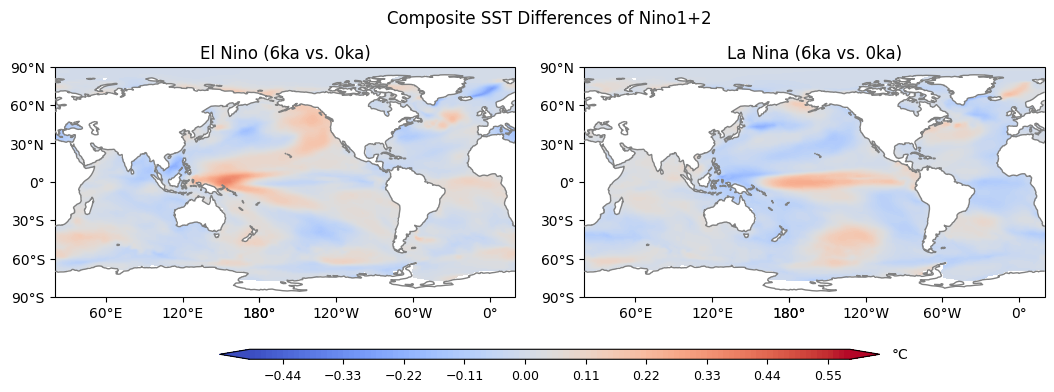

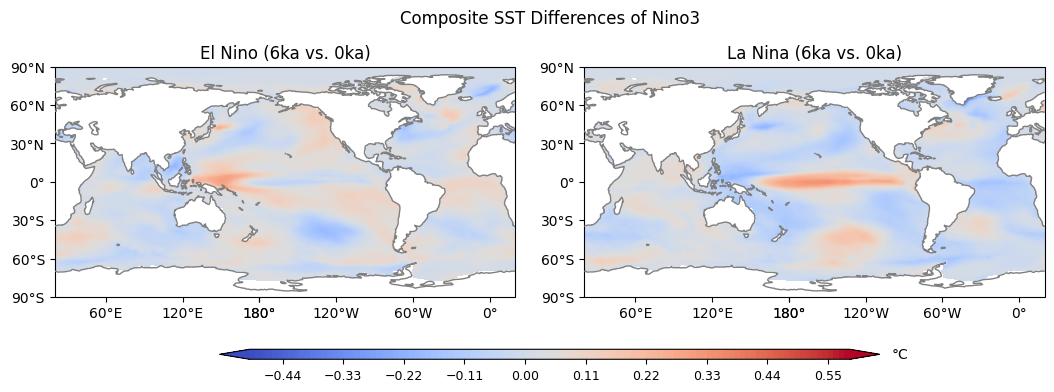

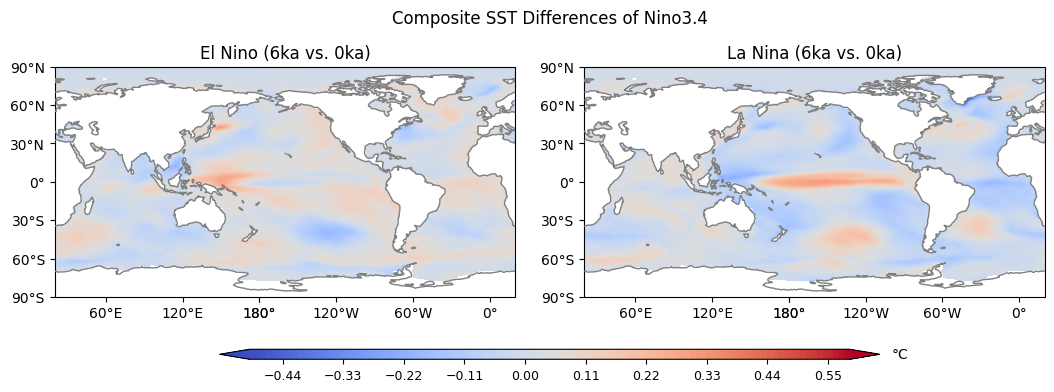

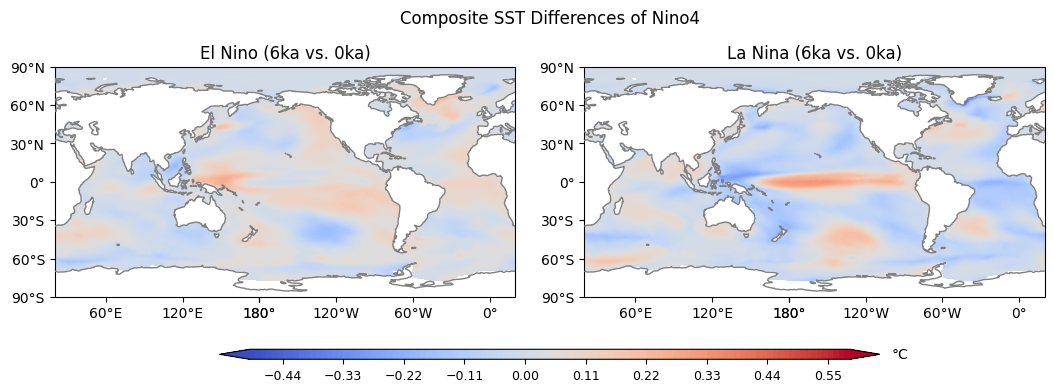

In [98]:
mh_vs_pi(0)
mh_vs_pi(1)
mh_vs_pi(2)
mh_vs_pi(3)